In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os #File location
from wordcloud import WordCloud #Word visualization
import matplotlib.pyplot as plt #Plotting properties
import seaborn as sns #Plotting properties
from sklearn.feature_extraction.text import CountVectorizer #Data transformation
from sklearn.model_selection import train_test_split #Data testing
from sklearn.linear_model import LogisticRegression #Prediction Model
from sklearn.metrics import accuracy_score #Comparison between real and predicted
from sklearn.preprocessing import LabelEncoder #Variable encoding and decoding for XGBoost
import re #Regular expressions
import nltk
from nltk import word_tokenize
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iamaf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_data = pd.read_csv(r"D:\Ultimate Programming\Data Bases\Project Dataset\Twitter\twitter_training.csv")
val_data = pd.read_csv(r"D:\Ultimate Programming\Data Bases\Project Dataset\Twitter\twitter_validation.csv")
col = ['Tweet Id', 'Entity','Sentiment','Tweet Content']
train_data.columns = col
val_data.columns = col

In [3]:
train_data.head(2)

,Tweet Id,Entity,Sentiment,Tweet Content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...


In [4]:
val_data.head(2)

,Tweet Id,Entity,Sentiment,Tweet Content
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...


# Data Cleaning

In [5]:
train_data.shape

(74681, 4)

In [6]:
train_data.dropna(inplace=True)

In [7]:
print(train_data.isnull().sum().sum())

0


In [8]:
train_data.duplicated().sum()

np.int64(2340)

In [9]:
train_data.drop_duplicates(inplace=True)
print(train_data.shape)

(71655, 4)


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71655 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet Id       71655 non-null  int64 
 1   Entity         71655 non-null  object
 2   Sentiment      71655 non-null  object
 3   Tweet Content  71655 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


In [11]:
train_data.head(4)

,Tweet Id,Entity,Sentiment,Tweet Content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


# Exploratory Data Analysis (EDA)

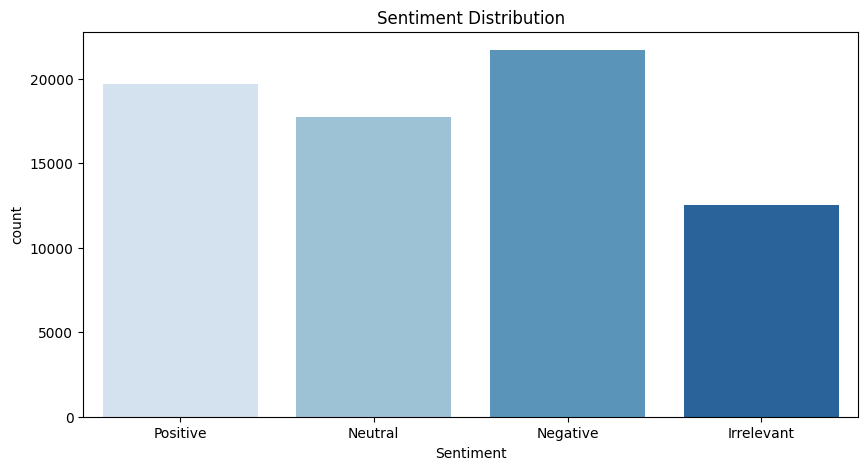

In [12]:
plt.figure(figsize=(10, 5))
sns.countplot(data=train_data, x='Sentiment', palette="Blues")
plt.title('Sentiment Distribution')
plt.show()

In [13]:
train_data["lower"]=train_data["Tweet Content"].astype(str).str.lower() #lowercase
train_data["lower"]=[str(data) for data in train_data.lower] #converting all to string
train_data["lower"]=train_data.lower.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)) #regex

In [14]:
val_data["lower"]=val_data["Tweet Content"].astype(str).str.lower() #lowercase
val_data["lower"]=[str(data) for data in val_data.lower] #converting all to string
val_data["lower"]=val_data.lower.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)) #regex

In [15]:
train_data.head(2)

,Tweet Id,Entity,Sentiment,Tweet Content,lower
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you ...


In [16]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

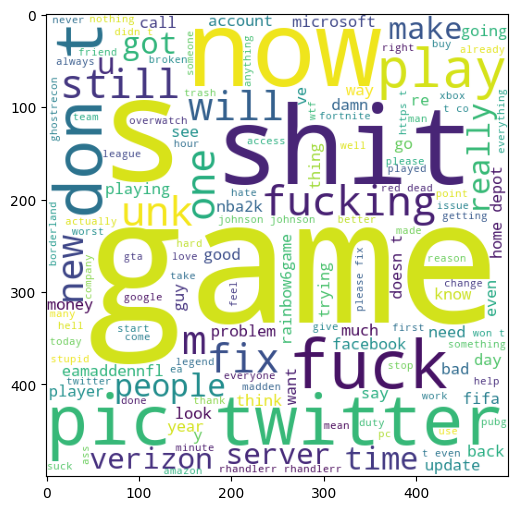

In [17]:
neg_wc = wc.generate(train_data[train_data['Sentiment'] == "Negative"]['lower'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(neg_wc)
plt.show()

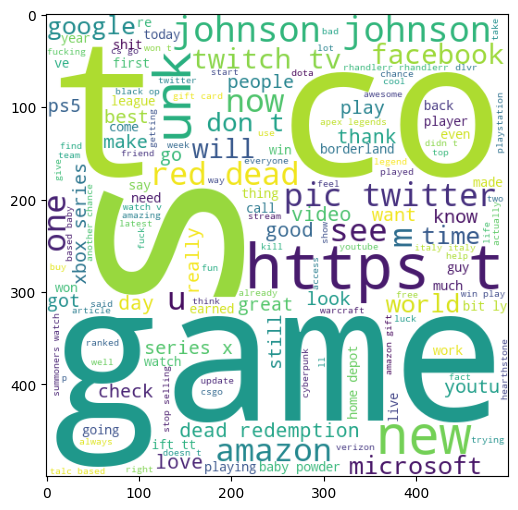

In [18]:
neutral_wc = wc.generate(train_data[train_data['Sentiment'] == "Neutral"]['lower'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(neutral_wc)
plt.show()

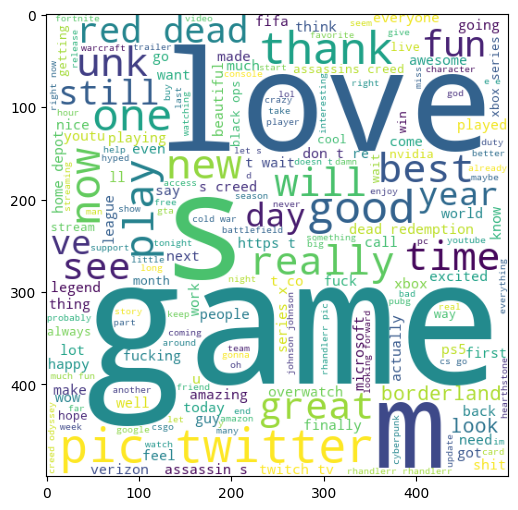

In [19]:
pos_wc = wc.generate(train_data[train_data['Sentiment'] == "Positive"]['lower'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(pos_wc)
plt.show()

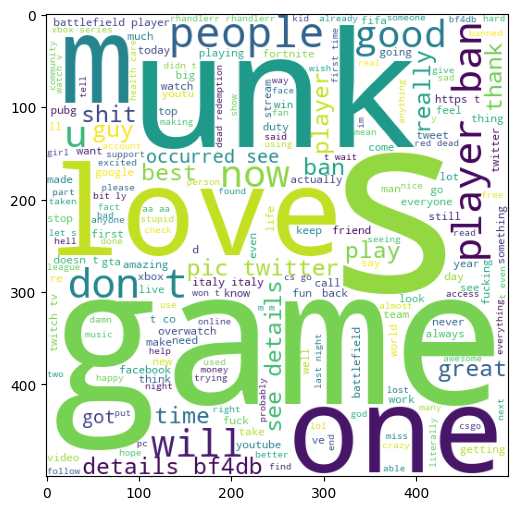

In [20]:
irr_wc = wc.generate(train_data[train_data['Sentiment'] == "Irrelevant"]['lower'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(irr_wc)
plt.show()

In [21]:
plot1=train_data.groupby(by=["Entity","Sentiment"]).count().reset_index()
plot1.head()

,Entity,Sentiment,Tweet Id,Tweet Content,lower
0,Amazon,Irrelevant,185,185,185
1,Amazon,Negative,565,565,565
2,Amazon,Neutral,1197,1197,1197
3,Amazon,Positive,302,302,302
4,ApexLegends,Irrelevant,185,185,185


In [22]:
#Text splitting
tokens_text = [word_tokenize(str(word)) for word in train_data.lower]
#Unique word counter
tokens_counter = [item for sublist in tokens_text for item in sublist]
print("Number of tokens: ", len(set(tokens_counter)))

Number of tokens:  30435


In [23]:
print(tokens_text[1], end = " ")

['im', 'getting', 'on', 'borderlands', 'and', 'i', 'will', 'kill', 'you', 'all'] 

In [24]:
#Choosing english stopwords
stopwords_nltk = nltk.corpus.stopwords
stop_words = stopwords_nltk.words('english')
stop_words[:6]

['a', 'about', 'above', 'after', 'again', 'against']

In [25]:
#Initial Bag of Words
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=stop_words, #English Stopwords
    ngram_range=(1, 1) #analysis of one word
)

In [26]:
reviews_train, reviews_test = train_test_split(train_data, test_size=0.2, random_state=0)

In [27]:
#Creation of encoding related to train dataset
X_train_bow = bow_counts.fit_transform(reviews_train.lower)
#Transformation of test dataset with train encoding
X_test_bow = bow_counts.transform(reviews_test.lower)

In [28]:
#Labels for train and test encoding
y_train_bow = reviews_train['Sentiment']
y_test_bow = reviews_test['Sentiment']

In [29]:
#Total of registers per category
y_test_bow.value_counts() / y_test_bow.shape[0]

Sentiment
Negative      0.306957
Positive      0.269067
Neutral       0.243319
Irrelevant    0.180657
Name: count, dtype: float64

In [30]:
#n-gram of 4 words
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    ngram_range=(1,4)
)
#Data labeling
X_train_bow = bow_counts.fit_transform(reviews_train.lower)
X_test_bow = bow_counts.transform(reviews_test.lower)
X_val_bow = bow_counts.transform(val_data.lower)

In [31]:
model2 = LogisticRegression(C=0.9, solver="liblinear",max_iter=1500)
# Logistic regression
model2.fit(X_train_bow, y_train_bow)
# Prediction
test_pred_2 = model2.predict(X_test_bow)
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_2) * 100)

Accuracy:  91.27764984997557


In [32]:
y_val_bow = val_data['Sentiment']
Val_pred_2 = model2.predict(X_val_bow)
print("Accuracy: ", accuracy_score(y_val_bow, Val_pred_2) * 100)

Accuracy:  98.8988988988989


In [33]:
train_data.head(2)

,Tweet Id,Entity,Sentiment,Tweet Content,lower
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you ...


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [35]:
text_column = 'lower'  # Your cleaned text column

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', CountVectorizer(tokenizer=word_tokenize, ngram_range=(1,4)), text_column)
    ]
)

In [36]:
# Now, set up the full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(C=0.9, solver="liblinear",max_iter=1500))
])

# Fit the pipeline
pipeline.fit(train_data, train_data['Sentiment'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  CountVectorizer(ngram_range=(1,
                                                                               4),
                                                                  tokenizer=<function word_tokenize at 0x00000197200E8220>),
                                                  'lower')])),
                ('clf',
                 LogisticRegression(C=0.9, max_iter=1500, solver='liblinear'))])

In [37]:
# Predict on validation set
pred_val = pipeline.predict(val_data)

# Save the pipeline for later use
import joblib
joblib.dump(pipeline, 'model.pkl')

['model.pkl']